# cotton Disease Classification

Dataset credits: https://www.kaggle.com/datasets/dhamur/cotton-plant-disease?resource=download

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline 

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3118 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy',
 'Powdery Mildew',
 'Target spot']

In [5]:
for image_batch, label_batch in dataset.take(1): #take 1 batch
    print(image_batch.shape) # 32 images and each image is 256,256 and 3 is for RGB channels
    print(label_batch.numpy()) #32 images labeled in 5 diseases and 1 healthy classs 

(32, 256, 256, 3)
[2 3 1 4 3 0 2 3 1 0 1 2 5 1 3 3 1 1 3 0 4 0 1 5 0 4 5 4 4 2 1 5]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

if we want to visualize first image

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 74.24945    118.67914     73.202576  ]
  [ 74.09375    120.79523     74.79523   ]
  [ 71.305115   120.74768     77.48248   ]
  ...
  [  2.4714966   13.471497     0.3828125 ]
  [  1.3856812   11.076477     0.27178955]
  [  5.024536    16.024536     2.0245361 ]]

 [[ 75.02673    121.43628     74.23151   ]
  [ 72.95599    120.32526     74.140625  ]
  [ 67.35199    118.29602     72.64801   ]
  ...
  [  5.0217285   16.021729     2.3737183 ]
  [  5.28125     16.28125      2.7713623 ]
  [  4.157898    15.157898     1.157898  ]]

 [[ 69.99408    118.35895     70.17651   ]
  [ 70.17572    119.47174     70.82373   ]
  [ 66.52936    118.52936     70.52936   ]
  ...
  [  6.0549316   17.054932     3.0549316 ]
  [  6.1727295   17.17273      3.3372192 ]
  [  4.1875      15.1875       1.3878784 ]]

 ...

 [[152.90222    182.28503    176.1366    ]
  [146.98737    176.37018    170.22174   ]
  [150.55847    179.55847    175.17566   ]
  ...
  [130.11743    161.49835    152.64868   ]
  [121.63281    15

### Visualize some of the images from our dataset

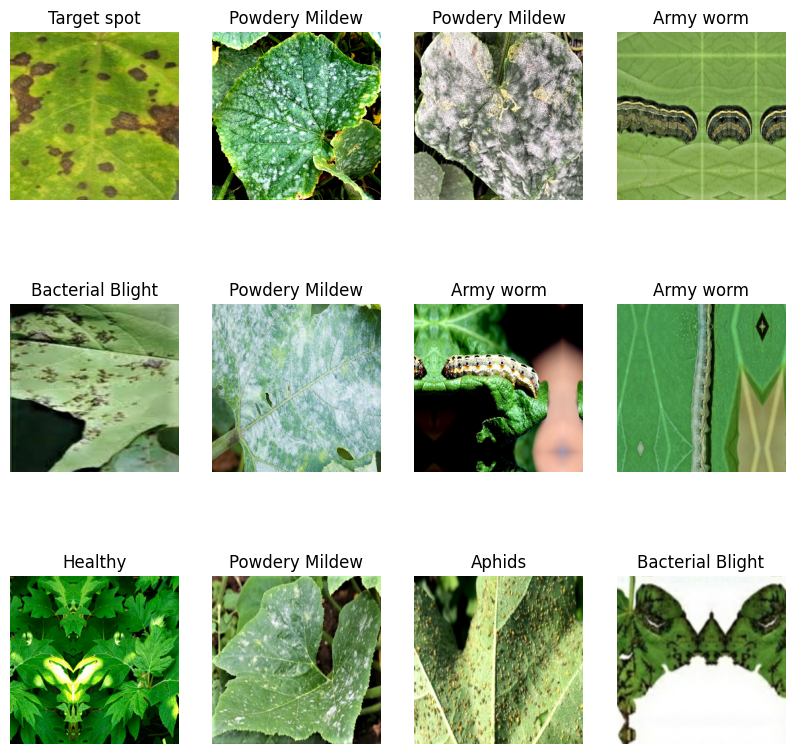

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset) #3118/32 = 97.43

98

In [9]:
98*32 #last batch is not perfect thats why giving 3136

3136

In [10]:
train_size = 0.8
len(dataset)*train_size

78.4

In [11]:
train_ds = dataset.take(78)
len(train_ds)

78

In [12]:
test_ds = dataset.skip(78)
len(test_ds)

20

In [13]:
val_size=0.1
len(dataset)*val_size

9.8

In [14]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [15]:
test_ds = test_ds.skip(9)
len(test_ds)

11

performing train test split using single function

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1 #assertion statement: ensures the sum of splits equals 1 (100%).
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

78

In [19]:
len(val_ds)

9

In [20]:
len(test_ds)

11

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Rescaling

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),

])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer.using CNN because it is popular for image classification tasks. We also add the initial layers for resizing, normalization and Data Augmentation.

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, #Progress Bar Mode (Shows a detailed progress bar for each epoch)
    epochs=20,
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.2177 - loss: 1.7302 - val_accuracy: 0.3090 - val_loss: 1.6052
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.4051 - loss: 1.4566 - val_accuracy: 0.4167 - val_loss: 1.3807
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.4931 - loss: 1.2746 - val_accuracy: 0.4722 - val_loss: 1.2672
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5456 - loss: 1.1586 - val_accuracy: 0.5486 - val_loss: 1.2284
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5905 - loss: 1.0283 - val_accuracy: 0.6493 - val_loss: 1.0268
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6457 - loss: 0.9013 - val_accuracy: 0.6354 - val_loss: 1.0868
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.6428 - loss: 0.8988 - val_accuracy: 0.6875 - val_loss: 0.8702
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.6807 - loss: 0.8680 - val_accuracy: 0.7153 - v

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 14ms/step - loss: 0.0063 - accuracy: 1.0000


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores

[0.006251859944313765, 1.0]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8801848292350769,
 0.6033139228820801,
 0.3646925389766693,
 0.2776017189025879,
 0.24480397999286652]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

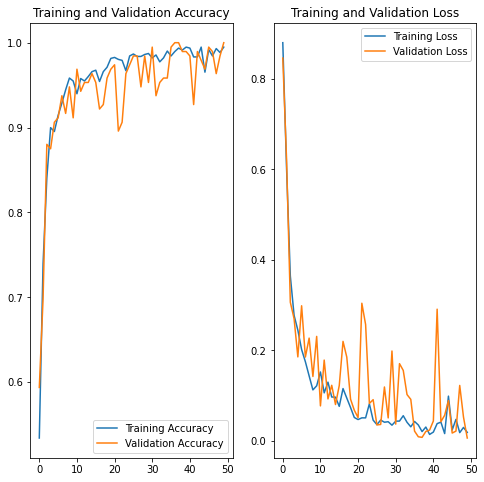

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


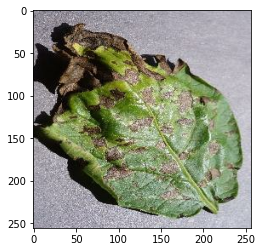

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

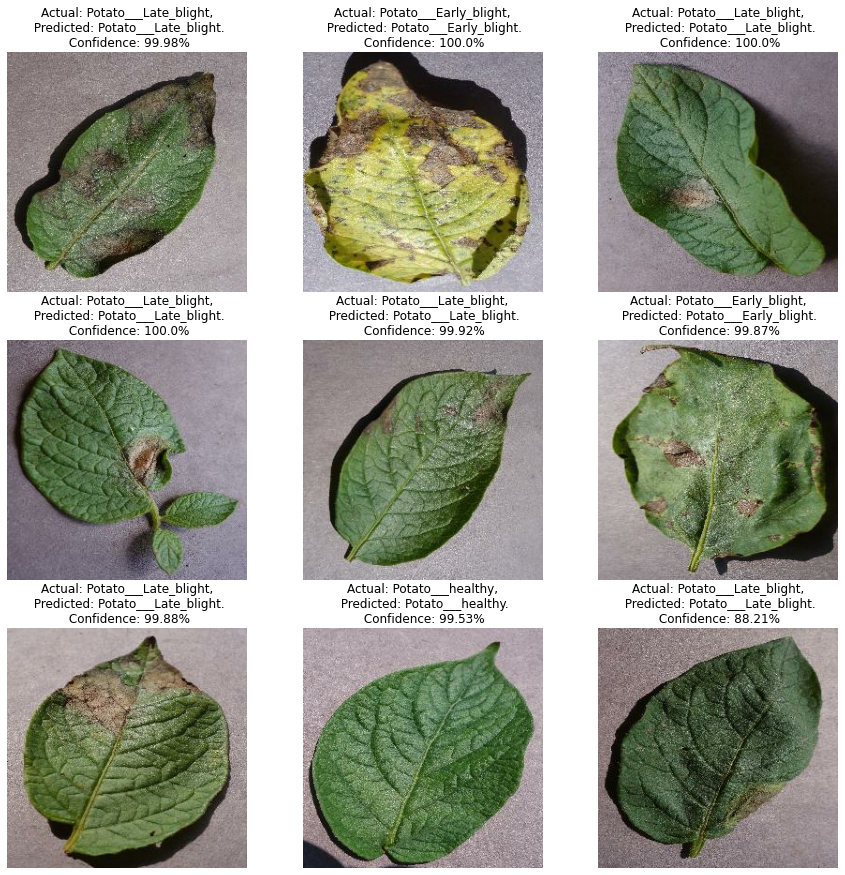

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3/assets


In [ ]:
model.save("../potatoes.h5")